<sup>This notebook is originally from https://github.com/lizanafj/POE_techniques and licensed for reuse under [MIT license].</sup>

# Discrepancies between occupancy and HVAC operation
---

This notebook is part of a set of data-based fault detection and diagnosis techniques. 

Specifically, this notebook performs an **evaluation of the real building occupancy**. It quantifies the percentage of time with real occupancy in the building per working hour. 

In [1]:
import os

import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import datetime


# get folder location of script
cwd = os.getcwd()

## Import data
---
Import required data to perform the analysis

In [2]:
#Access to folder with data: 
os.chdir(cwd)
cwd_data = cwd+r"\Data"
os.chdir(cwd_data)

In [3]:
#data
data = pd.read_csv('HH_Indoor_Office_IEQsensor_3.csv',sep=";",index_col = "Time", parse_dates=True).tz_localize(None)
data = data.sort_index()

## Explore data
---
See variables, datetime, and data structure.

In [4]:
#See dataframe
data.head()

CO2      H  LUX  PIR    RAD      T  WIND
Time                                                         
2022-01-12 00:04:00  941  35.20    0  0.0  19.82  21.49  0.09
2022-01-12 00:09:00  936  35.19    0  0.0  19.82  21.48  0.08
2022-01-12 00:14:00  932  35.23    0  0.0  19.83  21.45  0.09
2022-01-12 00:19:00  931  35.18    0  0.0  19.82  21.45  0.09
2022-01-12 00:24:00  925  35.19    0  0.0  19.80  21.43  0.08

<AxesSubplot:xlabel='Time'>

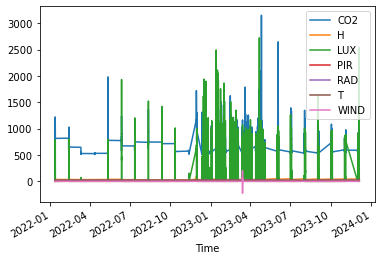

In [5]:
#Visualise variables
data.plot()

## Data pre-processing
---

Filtering and cleaning steps before the analysis 


In [6]:
#truncate timeframe
data = data.truncate(before="2022-12-01",after="2023-02-28 23:00")

In [7]:
#Data selection
data1 = data[["PIR","LUX"]]

In [8]:
#Data resample - hourly mean
data2 = data1.resample("1H").mean()

#For the motion sensor (PIR), we want the sum per hour, not the mean - So, we replace the time series data
data2["PIR"] = data1["PIR"].resample("1H").sum()

In [9]:
data2.head()

PIR  LUX
Time                         
2022-12-12 00:00:00  0.0  0.0
2022-12-12 01:00:00  0.0  0.0
2022-12-12 02:00:00  0.0  0.0
2022-12-12 03:00:00  0.0  0.0
2022-12-12 04:00:00  0.0  0.0

<AxesSubplot:xlabel='Time'>

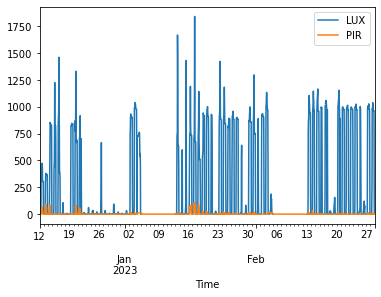

In [10]:
data2[["LUX","PIR"]].plot()

In [11]:
#Auxiliar variables
data2["week_day"] = data2.index.dayofweek
data2["hour_day"] = data2.index.hour
data2["occupancy"] = np.where((data2["hour_day"] > 8) & (data2["hour_day"] < 19) & (data2["week_day"]<5), 1, 0)
data2["real_occupancy"] = np.where((data2["hour_day"] > 8) & (data2["hour_day"] < 19) & (data2["week_day"]<5) & (data2["PIR"]>0.5), 1, 0)
data2["non_occupancy"] = np.where((data2["hour_day"] > 8) & (data2["hour_day"] < 19) & (data2["week_day"]<5) & (data2["PIR"]<0.5) , 1, 0)

## Data diagnosis
---
Diagnosis of building occupancy

In [13]:
#Analysis

#Real occupancy according to motion sensor
data_pir = data2[["real_occupancy","hour_day"]].reset_index(drop=True)
data_pir = data_pir.groupby(["hour_day"]).sum()

#Expected occupancy according to working hours
data_occ = data2[["occupancy","hour_day"]].reset_index(drop=True)
data_occ = data_occ.groupby(["hour_day"]).sum()

In [14]:
#Percentage of working hours with activity/occupancy
data_t = pd.concat([data_pir,data_occ],axis=1)
data_t["diff"] = data_t["real_occupancy"]/data_t["occupancy"]*100

data_t = data_t.fillna(0)

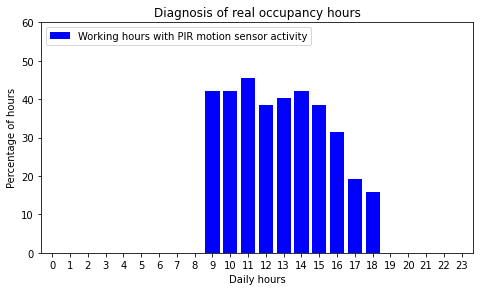

In [15]:
#Visualisation
fig=plt.figure()
ax=fig.add_axes([0,0,1,0.8])

ax.bar(data_t.index, data_t["diff"],color="b",label="Working hours with PIR motion sensor activity")

ax.set_xlabel('Daily hours')
ax.set_ylabel('Percentage of hours')
ax.set_title('Diagnosis of real occupancy hours')
ax.xaxis.set_ticks(np.arange(0, 24, 1))
ax.set_ylim(0,60)
ax.margins(x=0.01)
ax.legend(loc=2)


plt.show()

In [16]:
print("Total working hours during the timeframe selected :", data2["occupancy"].sum())
print("Average percentage of working hours with occupancy: ", round(data2["real_occupancy"].sum()/data2["occupancy"].sum()*100,2),"%")

Total working hours during the timeframe selected : 570
Average percentage of working hours with occupancy:  35.61 %
